In [1]:
# === Clone, install, test repo ===

# 1) Clone your repo (replace with your URL)
!git clone https://github.com/seyeala/HW1_Applied_Deep_learning_ME405.git
%cd HW1_Applied_Deep_learning_ME405

# 2) Install in editable mode with Torch + video extras
!pip install -e .[torch,video] --quiet



Cloning into 'HW1_Applied_Deep_learning_ME405'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 98 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (98/98), 36.11 KiB | 6.02 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/HW1_Applied_Deep_learning_ME405
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mobile-gradio-classifier (pyproject.toml) ... done


In [2]:
%cd /content/HW1_Applied_Deep_learning_ME405
!pip install -e '.[torch,video]'


/content/HW1_Applied_Deep_learning_ME405
Obtaining file:///content/HW1_Applied_Deep_learning_ME405
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mobile-gradio-classifier (pyproject.toml) ... done
  Created wheel for mobile-gradio-classifier: filename=mobile_gradio_classifier-0.1.0-0.editable-py3-none-any.whl size=5829 sha256=3f01134cf489a025a8df169ef27c3c5391e141c112796793c0758227a843cbd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-nisf4rnk/wheels/14/b7/1f/747753271914f0d664693ba9fef80ab163851feb0905a85d0b
Successfully built mobile-gradio-classifier
  Attempting uninstall: mobile-gradio-classifier
    Found existing installation: mobile-gradio-classifier 0.1.0
    Uninstalling mobile-gradio-classifier-0.1.0:
      Successfully uninstalled mobile-gradio-classifier-0.1.0


In [4]:
!git pull

Already up to date.


In [5]:
%cd /content/HW1_Applied_Deep_learning_ME405

/content/HW1_Applied_Deep_learning_ME405


In [6]:
!python -m mobile_gradio_classifier.export_frames --config /content/HW1_Applied_Deep_learning_ME405/examples/frame_export.yaml

In [7]:
# --- Folder-labeled dataset → split → tf.data pipelines (Colab-ready) ---
import os, re, pathlib, numpy as np, tensorflow as tf
from typing import Optional, List

# =========================
# Configure these
# =========================
ROOT_DIR = "/content/HW1_Applied_Deep_learning_ME405/exports/frames"   # expects: ROOT_DIR/<class_name>/*.jpg|png|...
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
RATIOS = (0.7, 0.15, 0.15)        # train / val / test ; must sum to 1.0
USE_SESSION_AWARE_SPLIT = True    # keep entire "session*" folders in a single split
CACHE_IN_MEMORY = True
REPEAT_TRAIN = True               # repeat() to avoid "ran out of data" on small sets

# =========================
# Discover files + labels
# =========================
root = pathlib.Path(ROOT_DIR)
assert root.exists(), f"ROOT_DIR not found: {root}"

exts = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}
files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
assert files, f"No images found under {ROOT_DIR}"

def label_from_folder(p: pathlib.Path) -> str:
    return p.relative_to(root).parts[0]

labels_str = [label_from_folder(p) for p in files]
class_names = sorted(set(labels_str))
class_to_idx = {c:i for i,c in enumerate(class_names)}

paths  = np.array([str(p) for p in files])
labels = np.array([class_to_idx[s] for s in labels_str], dtype=np.int32)

def infer_session_id(p: pathlib.Path) -> Optional[str]:
    parts = p.relative_to(root).parts
    for part in parts:
        if re.match(r"^session[_\-]?\w*$", part, flags=re.I):
            return part
    for part in parts:
        if re.search(r"(day|night|am|pm|morning|evening|\bsession\d+\b)", part, re.I):
            return part
    return None

sessions = np.array([infer_session_id(p) for p in files], dtype=object)

print(f"Found {len(paths)} images across {len(class_names)} classes:")
for c in class_names:
    print(f"  - {c}: {int(np.sum(np.array(labels_str)==c))}")

# =========================
# Stratified (group-aware) split
# =========================
rng = np.random.default_rng(SEED)
tr, va, te = RATIOS
assert abs((tr+va+te)-1.0) < 1e-6

def stratified_group_split(y: np.ndarray, groups: Optional[np.ndarray]):
    n = len(y); idx = np.arange(n)
    train = np.zeros(n, bool); val = np.zeros(n, bool); test = np.zeros(n, bool)

    # Group ids (sessions) or per-file singletons
    if USE_SESSION_AWARE_SPLIT:
        group_ids = np.array([g if g is not None else f"singleton-{i}" for i,g in enumerate(groups)], dtype=object)
    else:
        group_ids = np.array([f"singleton-{i}" for i in range(n)], dtype=object)

    for cls_idx, cls_name in enumerate(class_names):
        sel = (y == cls_idx)
        i_cls = idx[sel]; g_cls = group_ids[sel]
        uniq_g = np.unique(g_cls); rng.shuffle(uniq_g)

        n_g = len(uniq_g)
        n_tr = max(1, int(round(tr * n_g)))
        n_va = max(0, int(round(va * n_g)))
        n_te = max(0, n_g - n_tr - n_va)

        tr_g = set(uniq_g[:n_tr])
        va_g = set(uniq_g[n_tr:n_tr+n_va])
        te_g = set(uniq_g[n_tr+n_va:])

        train[i_cls[np.isin(g_cls, list(tr_g))]] = True
        val[i_cls[np.isin(g_cls, list(va_g))]]   = True
        test[i_cls[np.isin(g_cls, list(te_g))]]  = True

    assert not np.any(train & val) and not np.any(train & test) and not np.any(val & test)
    return train, val, test

train_m, val_m, test_m = stratified_group_split(labels, sessions)

def summarize(name, m):
    cnt = int(m.sum())
    byc = ", ".join(f"{c}={int(np.sum(labels[m]==i))}" for i,c in enumerate(class_names))
    return f"{name}: {cnt} imgs | {byc}"

print(summarize("Train", train_m))
print(summarize("Val",   val_m))
print(summarize("Test",  test_m))

paths_train, labels_train = paths[train_m], labels[train_m]
paths_val,   labels_val   = paths[val_m],   labels[val_m]
paths_test,  labels_test  = paths[test_m],  labels[test_m]

# =========================
# tf.data pipelines
# =========================
AUTO = tf.data.AUTOTUNE

def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return img, label

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.08)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    img = tf.image.random_saturation(img, lower=0.9, upper=1.1)
    img = tf.clip_by_value(img + tf.random.normal(tf.shape(img), stddev=0.02), 0.0, 1.0)
    return img, label

def make_ds(paths_np, labels_np, training: bool):
    ds = tf.data.Dataset.from_tensor_slices((paths_np, labels_np))
    if training:
        ds = ds.shuffle(len(paths_np), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(lambda p,y: (tf.convert_to_tensor(p), tf.cast(y, tf.int32)), num_parallel_calls=AUTO)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
    if CACHE_IN_MEMORY:
        ds = ds.cache()
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    if training and REPEAT_TRAIN:
        ds = ds.repeat()
    return ds

train_ds = make_ds(paths_train, labels_train, training=True)
val_ds   = make_ds(paths_val,   labels_val,   training=False) if len(paths_val)  else None
test_ds  = make_ds(paths_test,  labels_test,  training=False) if len(paths_test) else None

print("\nPipelines ready.")
print(f"class_names = {class_names}")


Found 40 images across 2 classes:
  - door: 22
  - stopper: 18
Train: 28 imgs | door=15, stopper=13
Val: 6 imgs | door=3, stopper=3
Test: 6 imgs | door=4, stopper=2

Pipelines ready.
class_names = ['door', 'stopper']


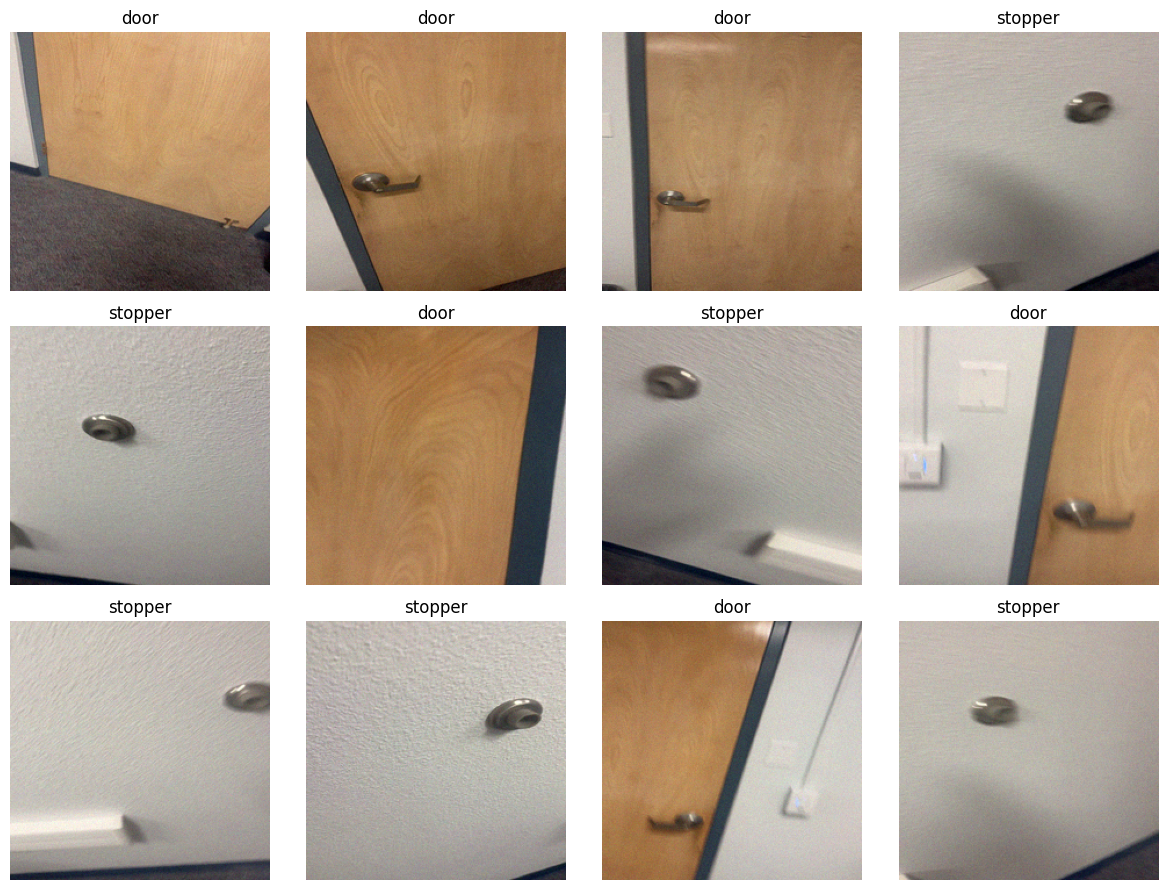

In [8]:
import matplotlib.pyplot as plt

# Take one batch from the train dataset
images, labels = next(iter(train_ds))

# Convert tensors to numpy
images = images.numpy()
labels = labels.numpy()

# Shuffle order for display
idxs = np.random.permutation(len(images))

# How many to show
n_show = min(12, len(images))   # show up to 12
rows = int(np.ceil(n_show/4))

plt.figure(figsize=(12, 3*rows))
for i in range(n_show):
    j = idxs[i]
    plt.subplot(rows, 4, i+1)
    plt.imshow(images[j])
    plt.title(class_names[labels[j]])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
# === InceptionV3 Transfer Learning (frozen, no fine-tuning), Keras 3-safe ===
# Assumes you already created:
#   - train_ds, val_ds, test_ds (tf.data pipelines)
#   - class_names (list of str)
#   - paths_train, paths_val, paths_test (np arrays)
#   - IMG_SIZE, BATCH_SIZE
import os, math, json, tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# ---- Config ----
NUM_CLASSES = len(class_names)
EPOCHS = 10
has_val = (val_ds is not None)

# (Optional housekeeping) remove old weights if present
ckpt_path = "best_inception.weights.h5"   # Keras requires .weights.h5 when save_weights_only=True
if os.path.exists(ckpt_path):
    os.remove(ckpt_path)

# ---- Build model ----
inputs = tf.keras.Input(shape=IMG_SIZE + (3,), name="image")
x = tf.keras.layers.Resizing(299, 299, name="resize_to_299")(inputs)
# InceptionV3 expects [-1, 1] range; our pipeline gives [0,1]
x = tf.keras.layers.Rescaling(scale=2.0, offset=-1.0, name="scale_to_m1_p1")(x)

base = InceptionV3(include_top=False, weights="imagenet")
base.trainable = False  # << No fine-tuning

x = base(x, training=False)  # keep BN layers in inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # mild regularization
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classifier")(x)

model = tf.keras.Model(inputs, outputs, name="inceptionv3_transfer")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# ---- Steps (works with repeat() pipelines) ----
def num_steps(n_items, batch):
    return max(1, math.ceil(n_items / batch))

train_steps = num_steps(len(paths_train), BATCH_SIZE)
val_steps   = num_steps(len(paths_val),  BATCH_SIZE) if has_val else None

# ---- Callbacks ----
monitor_metric = "val_loss" if has_val else "loss"
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,             # must end with .weights.h5 for save_weights_only=True
    monitor=monitor_metric,
    mode="min",
    save_best_only=True,
    save_weights_only=True,         # << keep weights only
    verbose=1,
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_metric, factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

# ---- Train ----
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,       # required when train_ds.repeat()
    validation_data=val_ds if has_val else None,
    validation_steps=val_steps if has_val else None,
    callbacks=[ckpt, rlr],
    verbose=1,
)

# ---- Load the best weights & evaluate ----
model.load_weights(ckpt_path)
print(f"Loaded best weights from: {ckpt_path}")

if has_val:
    vloss, vacc = model.evaluate(val_ds, steps=val_steps, verbose=0)
    print(f"Validation — loss: {vloss:.4f}, acc: {vacc:.4f}")

if test_ds is not None and len(paths_test) > 0:
    test_steps = num_steps(len(paths_test), BATCH_SIZE)
    tloss, tacc = model.evaluate(test_ds, steps=test_steps, verbose=0)
    print(f"Test — loss: {tloss:.4f}, acc: {tacc:.4f}")

# ---- (Optional) Save label map for inference-time decoding ----
with open("class_names.json", "w") as f:
    json.dump(class_names, f)
print("Saved class names to class_names.json")


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6786 - loss: 0.6306
Epoch 1: val_loss improved from inf to 0.35043, saving model to best_inception.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.6786 - loss: 0.6306 - val_accuracy: 1.0000 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7500 - loss: 0.5372
Epoch 2: val_loss improved from 0.35043 to 0.28084, saving model to best_inception.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step - accuracy: 0.7500 - loss: 0.5372 - val_accuracy: 1.0000 - val_loss: 0.2808 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8571 - loss: 0.4134
Epoch 3: val_loss improved from 0.28084 to 0.21669, saving model to best_inception.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step - accuracy: 0.8571 - loss: 0.4134 - val_accuracy: 1.0000 - val_loss: 0.2167 - learning_rate: 0.0010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accurac

Batch accuracy: 1.000  (6/6)


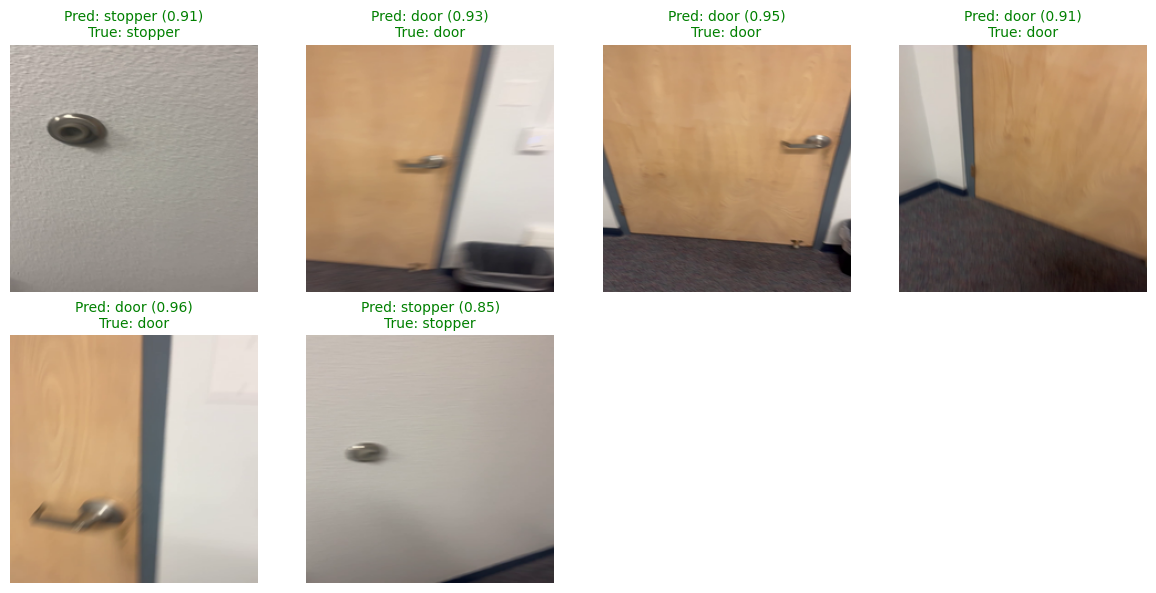

In [11]:

assert test_ds is not None and len(paths_test) > 0, "No test set available."

# Grab one batch
images, labels = next(iter(test_ds))
images_np = images.numpy()
labels_np = labels.numpy()

# Run inference
probs = model.predict(images, verbose=0)
pred_idxs = probs.argmax(axis=1)
pred_confs = probs.max(axis=1)



# Shuffle for display (random order)
rng = np.random.default_rng(123)
order = rng.permutation(len(images_np))

# How many to show
n_show = min(16, len(images_np))
rows = int(np.ceil(n_show / 4))

# Compute batch accuracy
batch_acc = (pred_idxs == labels_np).mean()
print(f"Batch accuracy: {batch_acc:.3f}  ({(pred_idxs==labels_np).sum()}/{len(labels_np)})")

plt.figure(figsize=(12, 3 * rows))
for i in range(n_show):
    j = order[i]
    plt.subplot(rows, 4, i + 1)
    plt.imshow(images_np[j])
    pred_name = class_names[pred_idxs[j]]
    true_name = class_names[labels_np[j]]
    conf = pred_confs[j]
    correct = (pred_idxs[j] == labels_np[j])
    title_color = "green" if correct else "red"
    plt.title(f"Pred: {pred_name} ({conf:.2f})\nTrue: {true_name}", color=title_color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
pathlib.Path("models").mkdir(parents=True, exist_ok=True)

# Save full model and class names
model.save("models/model.keras")
with open("models/class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved:", os.listdir("models"))

Saved: ['model.keras', 'class_names.json']


In [2]:
# runtime: Python 3.10+/Colab
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from PIL import Image

from mobile_gradio_classifier import MobileClassifierApp, EmailConfig  # make sure this file is on PYTHONPATH

# ----------------------
# 1) Model / Classes
# ----------------------
MODEL_PATH = Path("/content/HW1_Applied_Deep_learning_ME405/models/model.keras")   # <-- saved model location
IMG_SIZE = 224                            # must match your model's input size
CLASSES = ["door", "stopper"]

# Load the trained model
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Saved Keras model not found at {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

# ----------------------
# 2) Preprocess + predict
# ----------------------
def _preprocess_rgb(pil: Image.Image) -> np.ndarray:
    """PIL.Image -> (1, H, W, 3) float32 in [0,1]"""
    arr = pil.convert("RGB")
    arr = tf.image.resize(np.array(arr, dtype=np.uint8), (IMG_SIZE, IMG_SIZE))
    arr = tf.cast(arr, tf.float32) / 255.0
    return arr[None, ...].numpy()

def predict_fn(pil: Image.Image):
    """Return {label: prob} for the given PIL image."""
    logits_or_probs = model.predict(_preprocess_rgb(pil), verbose=0)[0]
    # Ensure probabilities sum ~1 (supports models that output logits)
    if (np.any(logits_or_probs < 0) or not np.isclose(np.sum(logits_or_probs), 1.0, atol=1e-3)):
        probs = tf.nn.softmax(logits_or_probs).numpy()
    else:
        probs = np.asarray(logits_or_probs, dtype=float)
    return {c: float(p) for c, p in zip(CLASSES, probs)}

# ----------------------
# 3) (Optional) Email Alerts (leave as None to disable)
# ----------------------
email_cfg = None
# Example config if needed:
# email_cfg = EmailConfig(
#     smtp_host="smtp.gmail.com",
#     smtp_port=587,
#     username="my-alerts@example.com",
#     password="your-app-password",   # use an app password, not your main password
#     use_tls=True,
#     from_addr="my-alerts@example.com",
#     to_addrs=["you@example.com"],
#     subject="Classifier Alert",
#     trigger_labels=["door", "stopper"],
#     min_confidence=0.90,
# )

# ----------------------
# 4) Launch the Gradio App
# ----------------------
app = MobileClassifierApp(
    classes=CLASSES,
    predict_fn=predict_fn,      # use loaded TF model
    email_config=email_cfg,     # set if you filled in email_cfg
)

# In Colab: open in a new browser tab for webcam access
app.launch(share=True, inbrowser=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b51af35fd067657f6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b51af35fd067657f6c.gradio.live


In [3]:
import gradio as gr; print(gr.__version__)


5.48.0
